# JusticeBot Project: Classifying sentences as facts or analysis

Our current task is to produce a binary classification system of sentences as **facts** or **analysis**. We use a bi-directional Recurrent Neural Network (RNN), specifically, a Gate Recurrent Unit model (GRU) to capture the various linguistic relations between the constituents of a sentence and output a two-dimensional vector representing the probability that the sentence belongs to either category.

## Implementation

Here we present the implementation of the classifier, which makes use of several modules and helper functions.

### External libraries

We use a number of external libraries to accomplish the task, in particular PyTorch, which is industry and academic standard of Deep Learning research and applications. Additionally, we include many pre-existing Python modules that specialise in tasks such as plotting, indicating progress, data frame management, etc.

In [2]:
import re
import gensim
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from nltk.stem.snowball import FrenchStemmer
import spacy
from spacy_lefff import LefffLemmatizer
import pickle

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2019-07-31 13:09:28,853 - matplotlib.pyplot - DEBUG - Loaded backend nbAgg version unknown.


### Data preprocessing

The dataset on which we train and validate our classifier is a corpus of approximately 500 M sentences labelled as either belonging to the facts or the analysis portion of the decision section of a document. The corpus is split into three sections according to standard practices: training, validation, and testing, following a distribution of 65%, 15% and 20% respectively.

In [3]:
# max_length = 50
# train_range=281057
# valid_range=112422
# test_range=168634
# datafile = './datasets/data_no_uncommon_words.csv'

# train_range=921306
# valid_range=212609+921306
# test_range=212609+921306-1417394
# datafile = './datasets/dataset_30k_.csv'
# with open(datafile) as f:
#     with open('./datasets/train_data.csv','w') as train:
#         for n in range(train_range):
#             line = f.readline()
#             sentence, tag = line.split(',')
#             sentence = re.sub("[0-9]*","",sentence)
#             if sentence != '' and len(sentence.split()) <= max_length: train.write(sentence+","+tag)
#     with open('./datasets/valid_data.csv','w') as valid:
#         for n in range(valid_range):
#             line = f.readline()
#             if line.split(',')[0] != '':
#                 sentence, tag = line.split(',')
#                 sentence = re.sub("[0-9]*","",sentence)
#                 if sentence != '' and len(sentence.split()) <= max_length: valid.write(sentence+","+tag)
#     with open('./datasets/test_data.csv','w') as test:
#         for n in range(test_range):
#             line = f.readline()
#             if line.split(',')[0] != '' and len(line.split(',')[0].split()) <= max_length: test.write(line)

We experimented with stemming and lemmatising our corpus as part of the pre-processing, but ultimately found that neither process affected our performance significantly.

In [4]:
# stemmer = FrenchStemmer()
# with open('train_data.csv') as f:
#     with open('train_data_stem.csv','w') as g:
#         for line in f:
#             sentence = line.split(',')[0].split()
#             tag = line.split(',')[1]
#             for i in range(len(sentence)):
#                 sentence[i] = stemmer.stem(sentence[i])
#             sentence = ' '.join(sentence)
#             if sentence != '':
#                 g.write(sentence+','+tag)
            
# with open('valid_data.csv') as f:
#     with open('valid_data_stem.csv','w') as g:
#         for line in f:
#             sentence = line.split(',')[0].split()
#             tag = line.split(',')[1]
#             for i in range(len(sentence)):
#                 sentence[i] = stemmer.stem(sentence[i])
#             sentence = ' '.join(sentence)
#             if sentence != '':
#                 g.write(sentence+','+tag)

In [5]:
# nlp = spacy.load('fr')
# french_lemmatiser = LefffLemmatizer()
# nlp.add_pipe(french_lemmatiser, name='lefff', after='parser')
# lines = []

# with open('train_data.csv') as f:
#     with open('train_data_lem.csv','w') as g:
#         for line in f:
#             sentence = line.split(',')[0]
#             tag = line.split(',')[1]
#             if sentence != "":
#                 sentence = nlp(sentence)
#                 sentence = [word.lemma_ for word in sentence]
#                 sentence = ' '.join(sentence)
#                 sentence = sentence+','+tag
#                 lines.append(sentence)
#         for line in lines: g.write(line)

# lines = []                
# with open('valid_data.csv') as f:
#     with open('valid_data_lem.csv','w') as g:
#         for line in f:
#             sentence = line.split(',')[0]
#             tag = line.split(',')[1]
#             if sentence != "":
#                 sentence = nlp(sentence)
#                 sentence = [word.lemma_ for word in sentence]
#                 sentence = ' '.join(sentence)
#                 sentence = sentence+','+tag
#                 lines.append(sentence)
#         for line in lines: g.write(line)

### Implementation of helper classes and functions
Our classification system uses a pre-trained word embedding model taken from the [WaCKy group](https://wacky.sslmit.unibo.it/doku.php?id=corpora), consisting of 155,562 word vectors designed to preserve semantic relations amongst its elements.

In [6]:
embeddings_file = "./frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin"
embeddings = gensim.models.KeyedVectors.load_word2vec_format(embeddings_file,binary=True,unicode_errors='ignore')
embeddings_tensor = torch.FloatTensor(embeddings.vectors)

2019-07-31 13:09:28,912 - gensim.models.utils_any2vec - INFO - loading projection weights from ./frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin
2019-07-31 13:09:28,914 - smart_open.smart_open_lib - DEBUG - {'uri': './frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'transport_params': None}
2019-07-31 13:09:31,151 - gensim.models.utils_any2vec - INFO - loaded (155562, 200) matrix from ./frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin


The `Lexicon` class is a helper class that contains mappings of words to indices, mappings of indices to words, and the total number of words in our embeddings model. This information will be useful when extracting the words from each sentence in our input and looking it up in our embeddings model.

In [7]:
class Lexicon:
    def __init__(self,embeddings):
        self.word2index = {token: token_index for token_index, token in enumerate(embeddings.index2word)}
        self.index2word = embeddings.index2word
        self.n_words = len(embeddings.index2word)
        
lexicon = Lexicon(embeddings)
with open('lexicon','wb') as file:
    pickle.dump(lexicon,file)

Our dataset is wrapped in the `FactsOrAnalysisDataset` subclass, meant to go along with the PyTorch `DataLoader` class, which allows for the simple creations of mini-batches, amongst other functionalities. The data is loaded as a Pandas dataframe as is processed at the `__getitem__` method so that each sentence is returned as a constant-length list of indices; these will be used to call the embedding vectors representing each word in the sentence. The code for the methods `indexesFromSentence`, `tensorFromSentence`, and `tensorsFromPair` was taken from the [Translation using seq2seq](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) tutorial by Sean Robertson.

In [8]:
class FactsOrAnalysisDataset(Dataset):
    def __init__(self,csv_file,max_length,lexicon,n_sentences=0):
        self.facts_or_analysis_frame = pd.read_csv(csv_file)
        if n_sentences > 0:
            self.facts_or_analysis_frame = self.facts_or_analysis_frame.iloc[0:n_sentences]
        self.max_length = max_length
        self.n_of_sentences = len(self.facts_or_analysis_frame.index) if n_sentences == 0 else n_sentences
        self.lexicon = lexicon
        self.n_unk = set()
        self.n_words=set()
    
    def __len__(self):
        return len(self.facts_or_analysis_frame)
    
    def __getitem__(self,index):
        sentence = self.facts_or_analysis_frame.iloc[index,0]
        annotation = self.facts_or_analysis_frame.iloc[index,1]
        tensor = self.tensorsFromPair(self.lexicon,(sentence,annotation))
        padding = self.max_length - len(tensor[0])
        tensor[0] = F.pad(tensor[0], pad=(0, padding), mode='constant', value=0)
        return tensor
    
    def indexesFromSentence(self,lexicon, sentence):
        index_list = []
        sentence = sentence.split(' ')
        for word in sentence:
            try:
                index = lexicon.word2index[word]
                self.n_words.add(word)
            except:
                index = 0
                self.n_unk.add(word)
            index_list.append(index)
        return index_list

    def tensorFromSentence(self,lexicon, sentence):
        indexes = self.indexesFromSentence(lexicon, sentence)
        return torch.tensor(indexes, dtype=torch.long)

    def tensorsFromPair(self,lexicon,pair):
        input_tensor = self.tensorFromSentence(lexicon, pair[0])
        target = pair[1]
        target_tensor = torch.tensor([1,0], dtype=torch.float) if target==1 else torch.tensor([0,1], dtype=torch.float)
        return [input_tensor, target_tensor]        

The `FactsOrAnalysis` class is the implementation of the architecture of our model. It consists of a multi-layered GRU network whose last hidden state is fed into an affine linear layer, which produces a 2D vector representing the probabilities of the sentence belonging to either the facts or the analysis sections of the text.

In [9]:
class FactsOrAnalysis(nn.Module):
    def __init__(self,hidden_size,dropout=.5,gru_dropout=.3,embedding_size=200):
        super(FactsOrAnalysis, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding.from_pretrained(embeddings_tensor)
        self.rnn = nn.GRU(embedding_size,
                          hidden_size,
                          num_layers=3,
                          batch_first=True,
                          bidirectional=True,
                          dropout=gru_dropout)
        self.linear = nn.Linear(hidden_size,2)
        self.softmax = nn.Softmax(dim=1)
        self.drop = nn.Dropout(dropout)
    
    def forward(self,input_tensor):
        output = self.embedding(input_tensor)
        output = self.drop(output)
        _, hidden = self.rnn(output)
        hidden = hidden[0]
#         hidden = self.drop(hidden)
        output = self.linear(hidden)
        return self.softmax(output)
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)   

The `train` function is the implementation of the training algorithm of our model for a single batch of sequences. The `valid` function, representing the validation step of the training, follows a similar implementation, except is skips the backward pass and the update on the parameters.

In [10]:
def train(input_tensor,target,model,optimiser,criterion):
    model.train()
    hidden = model.initHidden()
    optimiser.zero_grad()
    prediction = model(input_tensor)
    loss = criterion(prediction,target)
    loss.backward()
    clip_grad_norm_(model.parameters(),clip)
    optimiser.step()
    return loss.item(), prediction

In [11]:
def valid(input_tensor,target,model,criterion):
    model.eval()
    prediction = model(input_tensor)
    loss = criterion(prediction,target)
    return loss.item(), prediction

The `test` function is a simple wrapper of Scikit-Learn's implementation of the F1 score and accuracy metrics.

In [12]:
def test(target_tensor,prediction_tensor):
    t = target_tensor.cpu().detach().numpy()
    t = np.array([target[0] for target in t])
    
    p = prediction_tensor.cpu().detach().numpy()
    p = np.array([predic[0] for predic in p])
    p = p.round()
            
    return accuracy_score(t,p), f1_score(t,p), precision_score(t,p), recall_score(t,p)

The `trainIters` function implements the full training run over a dataset, including the setting of most all hyperparameters that we considered. It also contains the code for plotting the learning curves over the number of epochs.

In [54]:
def trainIters(model,train_dset,valid_dset,batch_size,n_epochs,learning_rate,weight_decay):
    ###########################################
    ## Stuff related to plotting ##############
    ###########################################
    plot_train_losses = []
    plot_valid_losses = []
    plot_train_acc = []
    plot_valid_acc = []
    plot_train_f1 = []
    plot_valid_f1 = []
    plot_loss = 0
    plot_count = 0
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ion()
    plt.ylim(0, 1)
    plt.xlim(0, n_epochs)
    plt.title("Learning curve")
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss value')
    ax.plot(plot_train_losses,label='Training loss')
    ax.plot(plot_valid_losses,label='Validation loss')
    ax.text(n_epochs/2,0.9,'Training accuracy:')
    ax.text(n_epochs/2,0.85,'Validation accuracy:')
    ax.text(n_epochs/2,0.75,'Training f1:')
    ax.text(n_epochs/2,0.70,'Validation f1:')
    fig.show()
    fig.canvas.draw()
    ###########################################
    ## Stuff related to plotting ##############
    ###########################################
        
    print("CUDA is available!" if torch.cuda.is_available() else "NO CUDA 4 U")
    
    optimiser = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)
    criterion = nn.BCELoss()
    train_dl = DataLoader(train_dset, batch_size=batch_size)
    valid_dl = DataLoader(valid_dset, batch_size=batch_size)
    
    for epoch in tqdm(range(1,n_epochs+1),desc='Epoch'):
        train_it = tqdm(train_dl,desc='Training',leave=False)
        for x,y in train_it:
            plot_count+=1
            input_tensor = x.to(device)
            target = y.to(device)
            train_loss, prediction = train(input_tensor,target,model,optimiser,criterion)
            plot_loss+=train_loss
            accuracy, f1, precision, recall = test(y,prediction)
            plot_train_acc.append(accuracy)
            plot_train_f1.append(f1)
            train_it.set_description('Training accuracy: {:.4f}'.format(accuracy))
            train_it.refresh()
        
        ####################################
        ## Stuff related to plotting #######
        ####################################
        plot_loss_avg = plot_loss / plot_count
        plot_train_losses.append(plot_loss_avg)
        plot_loss = 0
        plot_count = 0
        ####################################
        ## Stuff related to plotting #######
        ####################################
        
        with torch.no_grad():
            counter = 0
            valid_loss = 0
            valid_it = tqdm(valid_dl,desc='Validation',leave=False)
            for x, y in valid_it:
                counter+=1
                input_tensor = x.to(device)
                target = y.to(device)
                v_loss, valid_pred = valid(input_tensor,target,model,criterion)
                valid_loss+=v_loss
                valid_acc, valid_f1, valid_prec, valid_rec = test(y,valid_pred)
                plot_valid_acc.append(valid_acc)
                plot_valid_f1.append(valid_f1)
                valid_it.set_description('Validation accuracy: {:.4f}'.format(valid_acc))
                valid_it.refresh()
                
            plot_valid_losses.append(valid_loss/counter)
            
        
#         if epoch % 6 == 0:
#             for g in optimiser.param_groups:
#                 g['lr'] = g['lr']*0.1

        ####################################
        ## Stuff related to plotting #######
        ####################################
        tr_acc = sum(plot_train_acc)/len(plot_train_acc)
        tr_f1 = sum(plot_train_f1)/len(plot_train_f1)
        va_acc = sum(plot_valid_acc)/len(plot_valid_acc)
        va_f1 = sum(plot_valid_f1)/len(plot_valid_f1)
    
        ax.clear()
        plt.ylim(0, 1)
        plt.xlim(0, n_epochs)
        plt.title("Learning curve")
        plt.xlabel('Number of epochs')
        plt.ylabel('Loss value')
        ax.plot(plot_train_losses,label='Training loss')
        ax.plot(plot_valid_losses,label='Validation loss')
        ax.text(n_epochs/2,0.9,'Training accuracy: {:.4f}'.format(tr_acc))
        ax.text(n_epochs/2,0.85,'Validation accuracy: {:.4f}'.format(va_acc))
        ax.text(n_epochs/2,0.75,'Training f1: {:.4f}'.format(tr_f1))
        ax.text(n_epochs/2,0.70,'Validation f1: {:.4f}'.format(va_f1))
        plt.legend(loc='upper left')
        fig.canvas.draw()

## Experimental run
Once the implementation is complete, the experiments consist mostly of loading the dataset, adjusting the hyperparameters, and training the model.

First, we load the split dataset into their corresponding training and validation containers.

In [13]:
train_ds = FactsOrAnalysisDataset('./datasets/train_data.csv',lexicon=lexicon,max_length=50,n_sentences=0)
valid_ds = FactsOrAnalysisDataset('./datasets/valid_data.csv',lexicon=lexicon,max_length=50,n_sentences=0)
test__ds = FactsOrAnalysisDataset('./datasets/test_data.csv',lexicon=lexicon,max_length=50,n_sentences=0)

Next, we create the model and adjust the hyperparameters

In [70]:
hidden_size = 256
model = FactsOrAnalysis(hidden_size,dropout=0,gru_dropout=0).to(device)
batch_size = 512
learning_rate = 1e-3
n_epochs = 40
clip = 0.2
weight_decay=0.0001

Finally, we call `trainIters` to begin the training of the model.

<IPython.core.display.Javascript object>


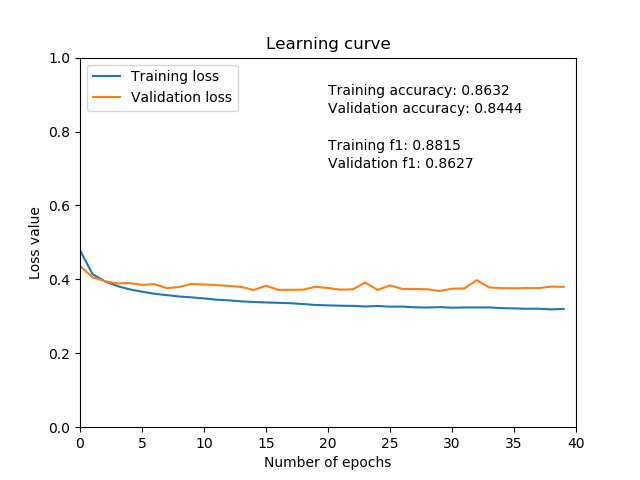

CUDA is available!


In [71]:
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING) 
plot_losses = trainIters(model,train_ds,valid_ds,batch_size,n_epochs,learning_rate,weight_decay)

## Hands-on demonstration
The following is a simple demonstration of the model.

First, we load the model

In [14]:
# torch.save(model,'./justicebot_model')
loaded_model = torch.load('./justicebot_model').to(torch.device('cpu'))

Then we select a small, random sample of sentences from the validation dataset

In [73]:
sentences= [
            "il se plaint également des pertes électricité dans son logement en raison un problème de fusible et du froid qui entre dans son logement et qui passe sous la porte de son balcon",
            "certains jugements exigent que avis soit assez précis quant à ces mentions",
            "le logement t il été remis en état",
            "l avis doit de plus indiquer la durée proposée du bail si le locateur propose de la modifier et le délai accordé au locataire pour refuser la modification proposée",
           ]

Finally, we convert each sentence into a stream of indices and pass them through our model and output the result

In [74]:
sentences= [train_ds.tensorFromSentence(lexicon,sentence) for sentence in sentences]
sentences = [loaded_model(sentence.view(1,-1)) for sentence in sentences]
for sentence in sentences: print(sentence[0][0].item())

0.8847429752349854
0.11373676359653473
0.5005398988723755
0.31274744868278503


In [15]:
# import numpy as np
# import matplotlib.pyplot as plt

# m = 100
# n = 100
# matrix = np.random.normal(0,1,m*n).reshape(m,n)
# matrix2 = np.random.normal(0,1,m*n).reshape(m,n)
# print(matrix.shape)

# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.ion()

# fig.show()
# fig.canvas.draw()

# for i in range(0,100):
#     ax.clear()
#     ax.plot(matrix[i,:])
#     ax.plot(matrix2[i,:])
#     fig.canvas.draw()

In [40]:
# train_ds.facts_or_analysis_frame.iloc[0,0]
# sentences = [train_ds.facts_or_analysis_frame.iloc[i,0] for i in range(train_ds.n_of_sentences)]
# sentences = [train_ds.indexesFromSentence(lexicon,sentence) for sentence in sentences]
# print('n_unk: %d' % len(train_ds.n_unk))
# print('n_words: %d' % len(train_ds.n_words))
